In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from requests import get
import json 
import os 
from collections import defaultdict


#Plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import folium #  conda install -c conda-forge folium
from folium import plugins
import geopandas as gpd



# Our helpers
from neural import prepare_future, predict_future # Wrapper to use RNNs
from helpfunc import *
from plots import *

%load_ext autoreload
%autoreload 2

In [115]:
path_dict = {'food_balance_africa': 'data/raw/FoodBalanceSheets_E_Africa_1.csv',
                'geoworld_json': 'data/raw/world-countries.json',
                'africa_supply_rnn': 'data/processed/africa_cal.pkl',
                'ages_calories_demand': 'data/raw/calories_demand.xlsx',
                'african_countries_list': "data/raw/african_countries.txt",
                'population_age_male': "data/raw/POPULATION_BY_AGE_MALE.xlsx",
                'population_age_female': "data/raw/POPULATION_BY_AGE_FEMALE.xlsx",
                'food_balance_europe': "data/raw/FoodBalanceSheets_E_Europe_1.csv",
                'europe_supply_rnn': 'data/processed/europe_cal.pkl',
                'european_countries_list': "data/raw/european_countries.txt", 
                'african_supply_map': 'visualization/africa_supply_map',
                'african_demand_anim': 'visualization/african_cal_diff_animation.html',
                'african_estimation_kcal': 'visualization/africa_est_kcal',
                'african_kcal_need': "visualization/african_kcal_need",
                 "european_supply_map":"visualization/african_kcal_need",
                 "african_pop_growth":"visualization/african_pop_growth.html", 
                 'european_pop_growth': "visualization/european_pop_growth.html",
                 'european_estimation_kcal': 'visualization/europe_est_kcal',
                 'european_demand_anim': 'visualization/european_cal_diff_animation.html',
                 'european_kcal_surplus': "visualization/european_kcal_surplus",
                 'world_kcal_surplus': "visualization/world_kcal_surplus",
            }

In [4]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

# Determination of African countries with food deficit

## 1) How much human food resources are available in African countries?

### 1.1) Preprocessing

To answer this important question, we will need to import data from the **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect to African countries only. 

In [5]:
food_balance_africa = pd.read_csv(path_dict['food_balance_africa'],encoding='latin-1');

Firstly, we will **remove** all the columns with title **"Y----F"** as they contain information about how the data was obtained (Calculated, Regression, Aggregate, FAO Estimation). In this context we will consider that FAO is a *highly renowned Agency* and hence we can assume these values are truthful without loss of generality. Furthermore we thought that it would be very handy to have numbers as columns representing years instead of **"Y----"**. We proceed on removing the letter **Y**. The helper functions `clean_Fs_and_years` does this cleaning on the dataframe.

In [6]:
food_balance_africa = clean_Fs_and_years(food_balance_africa)

Secondly, we replace all the **NAN** values with **0** as Item was not available.

In [7]:
food_balance_africa = food_balance_africa.fillna(0);

The third step to complete **the cleaning** of food_balance_africa consists of adapting names of countries in order to have consistency along our different dataframes. Since some countries changed their name over the years we will rename them. In particular, **Swaziland** to **Eswatini** and **South Africa** to **Southern Africa**. The function `replace_names_of_countries` takes the dataframe and the country names which should be replaced.

In [8]:
food_balance_africa = replace_names_of_countries(food_balance_africa, [('Swaziland', 'Eswatini'), ('South Africa', 'Southern Africa')])

Our Dataframe looks like this:

In [9]:
food_balance_africa.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,4,Algeria,2501,Population,511,Total Population - Both sexes,1000 persons,11561.0,11845.0,12136.0,...,33461.0,33961.0,34507.0,35097.0,35725.0,36383.0,37063.0,37763.0,38482.0,39208.0
1,4,Algeria,2511,Wheat and products,5511,Production,1000 tonnes,686.0,1507.0,1590.0,...,2731.0,2415.0,2688.0,2319.0,1111.0,2953.0,2605.0,2555.0,3432.0,3299.0
2,4,Algeria,2511,Wheat and products,5611,Import Quantity,1000 tonnes,469.0,501.0,374.0,...,5123.0,5697.0,4987.0,4885.0,6508.0,5757.0,5109.0,7487.0,6385.0,6343.0
3,4,Algeria,2511,Wheat and products,5072,Stock Variation,1000 tonnes,353.0,-409.0,-408.0,...,-456.0,-606.0,-459.0,-1.0,156.0,-484.0,515.0,-1050.0,-350.0,-180.0
4,4,Algeria,2511,Wheat and products,5911,Export Quantity,1000 tonnes,46.0,12.0,33.0,...,7.0,13.0,7.0,14.0,24.0,37.0,39.0,5.0,5.0,2.0


Analysing our DataFrame *food_balance_africa* we can see that it's already well structured since it contains many key - value couples such as **Item Code - Item** and **Element Code - Element** . More specifically, we will take advantage of this structure to filter out only rows characterized by **Grand total** as an **Item** and **Food supply (kcal/capita/day)** as an **Element**. The corresponding key-values are **(Item Code, 2901) and (Element Code, 664)**.
A reference to the documentation in the [FAO Website](http://www.fao.org/faostat/en/#data/FBS) explains the legend for Element Code and Element Item extensively. 

In order to keep our original Dataframe *food_balance_africa* as a reference we create a new Dataframe *food_supply_africa* in which we just keep **countries** and **food supplies** for every **year**.

In [10]:
food_supply_africa = obtain_supply(food_balance_africa)

We can now group group by **Area** and see the supplies derived from each item available in countries for that particular year.

In [11]:
food_supply_africa = food_supply_africa.set_index("Area")
food_supply_africa.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,
Algeria,1619.0,1569.0,1528.0,1540.0,1591.0,1571.0,1647.0,1706.0,1705.0,1675.0,...,2987.0,2958.0,3047.0,3041.0,3048.0,3110.0,3142.0,3217.0,3272.0,3296.0
Angola,1798.0,1819.0,1853.0,1862.0,1877.0,1890.0,1921.0,1856.0,1946.0,1965.0,...,2030.0,2077.0,2119.0,2173.0,2245.0,2303.0,2345.0,2407.0,2384.0,2473.0
Benin,1736.0,1758.0,1703.0,1669.0,1812.0,1804.0,1833.0,1935.0,1871.0,1812.0,...,2461.0,2435.0,2450.0,2564.0,2521.0,2565.0,2555.0,2598.0,2610.0,2619.0
Botswana,1976.0,1909.0,1972.0,2001.0,2005.0,1947.0,2010.0,2052.0,2013.0,2035.0,...,2191.0,2198.0,2150.0,2166.0,2184.0,2199.0,2234.0,2273.0,2342.0,2326.0
Burkina Faso,1326.0,1308.0,1452.0,1555.0,1571.0,1560.0,1587.0,1602.0,1604.0,1546.0,...,2505.0,2463.0,2559.0,2546.0,2588.0,2639.0,2681.0,2664.0,2707.0,2720.0


In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [12]:
food_supply_africa = food_supply_africa.transpose();

In [13]:
#converting the year from string to int
food_supply_africa.index = food_supply_africa.index.astype(int)

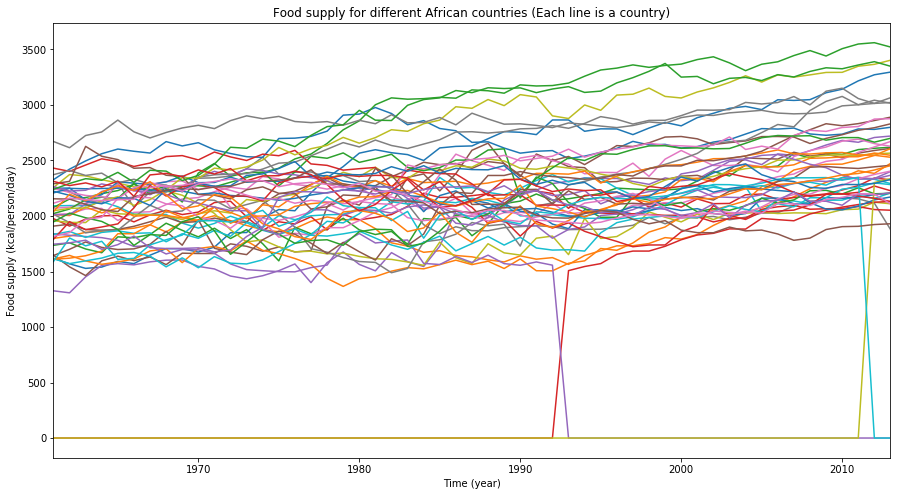

In [14]:
timeline_supply(food_supply_africa, "African")

This analysis shows that there are two inconsistencies. We therefore check for countries containing values equal to zero.

In [15]:
food_supply_africa.columns.values[(food_supply_africa == 0).any()]

array(['Ethiopia', 'Ethiopia PDR', 'Sudan', 'Sudan (former)'],
      dtype=object)

We notice that **Sudan** and **Ethiopia** appear twice as "Sudan" and "Sudan (former)" and "Ethiopia" and "Ethiopia PDR" respectively. This is due to the fact that South Sudan gained independence in 2011 (reference to https://en.wikipedia.org/wiki/South_Sudan), and the foundation of the Federal Democratic Republic of Ethiopia (reference to https://en.wikipedia.org/wiki/Ethiopia) in 1991. From then on, Ethiopia PDR was listed as Ethiopia. With food supply being consistently constant even after division, the newly introduced country "Sudan" is assumed to further on have accounted for both countries. For this reason, we will consider them to be one single country. 
Consequently, the two countries' data is merged into one continuous set each. The function `merge_countries` takes care of this, by substituting each key in dictionary (the second argument) with its value(s).

In [16]:
food_supply_africa = merge_countries(food_supply_africa, {'Sudan (former)': ['Sudan'], 'Ethiopia PDR': ['Ethiopia']})

Let's plot the newly generated data:

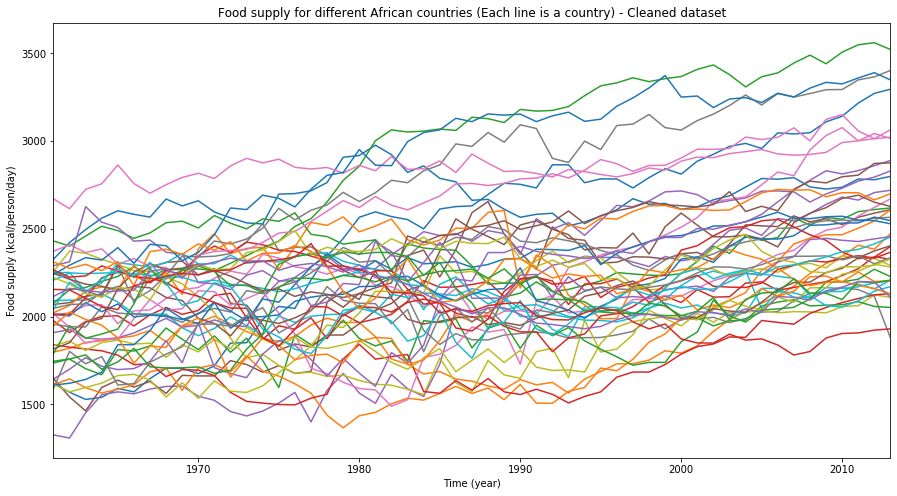

In [17]:
timeline_supply(food_supply_africa, "African", " - Cleaned dataset")

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios. `prepare_future` is used for this.

In [18]:
# Adding columns for the new years
food_supply_africa = prepare_future(food_supply_africa, 2014, 2020)

### 1.2) Extrapolation
First of all, we want to simulate data until 2020 to match the population data. Furthermore, we also want to be able to make predicitions for individual countries to assess if they might run into food shortages in the near future.  
The prediction for the new years are done by using a "*Recurrent Neural Network (RNN)*" and a window of size 10. Basically what we will do here is using all the past history of each country (windowed in block of 10 years each) to run a neural network and try to predict the future behaviour (up to 2020). The prediction won't be of high accuracy, as we don't have many future or many data to use. However, during our test using the data we already known we find that the neural networks are able to predict good estimations.  
As we don't want precise data, the **_estimations_** achieved by using ML are here more than acceptable for our purpose.  
*Credits*: We don't know much on RNN, so the network using here is adapted from the *Time series forecasting tutorial* on **Tensorflow**, available [here](https://www.tensorflow.org/tutorials/structured_data/time_series)  
*Note*: we already run the networks and saved the results on Colab, running them each time requires more than an hour on Colab. For this reason, we just use the pickle here instead of running the network. This is achieved by the function `predict_future`.

In [19]:
food_supply_africa = predict_future(food_supply_africa, path_dict['africa_supply_rnn'])

Plotting the results:

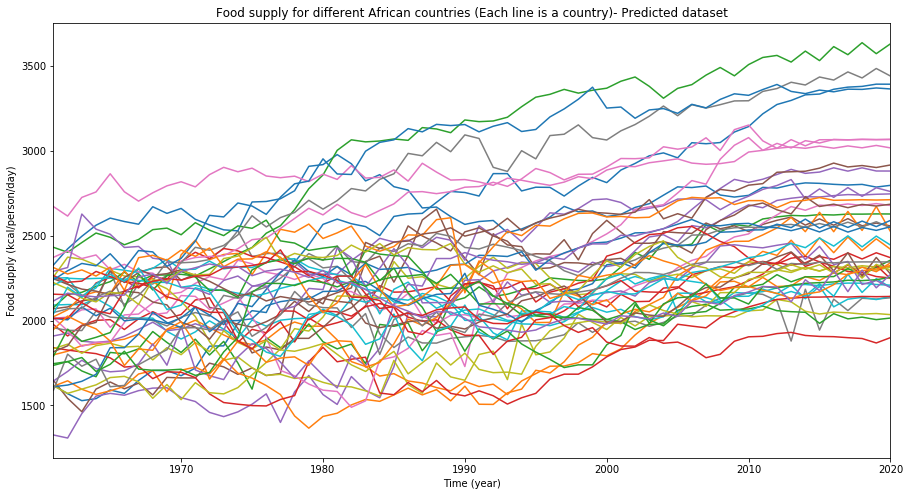

In [20]:
timeline_supply(food_supply_africa, "African", "- Predicted dataset")

### 1.3) Visualizing the data interactively

In [21]:
#Geographic coordinates for visualizing 
geojson_world = gpd.read_file(path_dict['geoworld_json'])
type(geojson_world)

geopandas.geodataframe.GeoDataFrame

We observe `geojson_world` is a **GeoDataFrame**. Let's see how the data are sorted:

In [22]:
geojson_world.head()

,id,name,geometry
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


We have to make sure that `geojson_world` has data for every country under our analysis. In this case, we need to check for every country in Africa and more specifically every country taken into account in `food_supply_africa`. Since the **name** in `geojson_world` is not a good index to match and we don't have any comparable **id** in `food_supply_africa` we have to do this job by hand since the size is small enough. As a result, we filter `geojson_world` to `geojson_africa`. Let's display this new GeoDataFrame.

In [90]:
african_country_codes = ["DZA","AGO","BEN","BWA","BFA","CMR","CAF","TCD","COD","CIV",
                         "DJI","EGY","SWZ","ETH","GAB","GMB","GHA","GNQ","GNB","KEN","LSO","LBR",
                         "MDG","MWI","MLI","MRT","MAR","MOZ","NAM","NER","NGA","RWA"
                         ,"SEN","SLE","ZAF","SDN","TGO","TUN","UGA","TZA","ZMB","ZWE"]

african_country_names = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
                         'Cameroon', 'Central African Republic', 'Chad', 'Congo',
                         "Côte d'Ivoire", 'Djibouti', 'Egypt', 'Eswatini','Ethiopia', 'Gabon',
                         'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
                         'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
                         'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Senegal',
                         'Sierra Leone', 'Southern Africa', 'Sudan', 'Togo',
                         'Tunisia', 'Uganda', 'United Republic of Tanzania', 'Zambia',
                         'Zimbabwe']

african_country_kv = pd.DataFrame({'codes': african_country_codes,
                                    'names': african_country_names
                                    })

geojson_africa = geojson_world[geojson_world.id.isin(african_country_codes)]
geojson_africa.head()

,id,name,geometry
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
13,BEN,Benin,"POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1...."
14,BFA,Burkina Faso,"POLYGON ((-2.82750 9.64246, -3.51190 9.90033, ..."
25,BWA,Botswana,"POLYGON ((25.64916 -18.53603, 25.85039 -18.714..."
26,CAF,Central African Republic,"POLYGON ((15.27946 7.42192, 16.10623 7.49709, ..."


The ordered list **african_country_codes** contains all the countries available to be plotted as geometry is available. We found out manually that **Cabo Verde, Sao Tome and Principe and Mauritius** are not in this list. For the sake of simplicity, we will removed these three countries as they don't affect too much our analysis. 

In [23]:
food_supply_africa = food_supply_africa.drop(columns=["Cabo Verde","Mauritius","Sao Tome and Principe"])

Now we can move to plot the Food supply for each of the country. All of this is done in the `plot_map` function. This function plot a world map centered in the interested zone with interactive value while moving over.  
As we are particularly interested on the *2020*, we'll plot on the notebook our prediction of supply just for this year in this map.  
**_Note_: the map will not be visualized without running, to see it [click here](https://manuleo.github.io/mADAm-2019/africa_supply_map.html)**  
If the reader is interested in looking at the data in previous decades the link is available here:

In [91]:
legend_name = "Food supply (kcal/person/day)"
for year in range(1970, 2030, 10):
    africa_supply_map = plot_map(food_supply_africa.T, path_dict['geoworld_json'], \
    african_country_kv, year, "Blues", legend_name, legend_name, path_dict['african_supply_map'] + str(year) + ".html")
africa_supply_map

## 2) What is the ideal amount of kcal each African country need?
In this first part, we compute **kcal demand** for males and females for every age group. Secondly, we will assert an extensive analysis on **African demographics**. Finally, we will be able to combine kcal demand with African population data into a unique dataframe that will be the answer of our inital question: **What is the kcal demand of a regular person in order to be healthy?**

### 2.1) How many kilocalories does a regular person need daily?

First off, we load the calories demand datasets scraped from the webpage [Calories](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/). This information will be matched with the population datsets to receive total calories demand in each country, each year.

In [24]:
male_calory_demand = pd.read_excel(path_dict['ages_calories_demand'], header = None, sheet_name = 0, names = ['age', 'sedentary', 'moderate', 'active'])

In [25]:
female_calory_demand = pd.read_excel(path_dict['ages_calories_demand'], header = None, sheet_name = 1, names = ['age', 'sedentary', 'moderate', 'active'])

In order to better work with the information we have collected, we will make some simplifications on the data. Mainly, we will:
- take the **active lifestyle** column in the calories demands database. According to the [World Health Organization](https://www.afro.who.int/health-topics/physical-activity), regular physical activity helps to maintain a healthy body and reduces the risk of disease.
- group the ages into ranges that match the ranges provided in the World Population Database

In [26]:
male_calories = male_calory_demand.drop(columns=['sedentary', 'moderate'])
female_calories = female_calory_demand.drop(columns=['sedentary', 'moderate'])
male_calories.rename(columns={'active':'input kcal'}, inplace=True)
female_calories.rename(columns={'active':'input kcal'}, inplace=True)

We have now obtained a caloric demand for simpler calculations in the future and stored in the two precedent datasets.  
Now, we need a  way to match the age groups in this dataframe to the ones in the population database we obtained. As such, let's analyse how ages are represented in our calory demand dataframes.

In [27]:
male_calories['age'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       '19-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50',
       '51-55', '56-60', '61-65', '66-70', '71-75', '76 and up', nan],
      dtype=object)

We can see that there are ranges of ages with different sizes (which makes sense, because different age groups have different caloric needs). The function `explode_age` returns the dataframe with one row per individual age.

We apply the function to our two dataframes:

In [28]:
male_calories = explode_age(male_calories)
female_calories = explode_age(female_calories)

In [29]:
male_calories['age'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101], dtype=int64)

Ages are now unique in each dataframe ( `male_calories` and `female_calories` ) and there's a caloric input value for each of them.

The last step to allow the match with the population database is to build the **same age groups** we have in that set. The `compress_ages` function takes care of the differences between datasets by grouping the **ages** into the same **ranges** as in the population dataset (and calculating the average needs).

We can lastly apply the function to the dataframes:

In [30]:
male_calories = compress_ages(male_calories)
female_calories = compress_ages(female_calories)

We also use the age group as new index and rename the columns:

In [31]:
male_calories.index.name = 'age_group'
male_calories = male_calories.rename(columns={0: 'input kcal'})
female_calories.index.name = 'age_group'
female_calories = female_calories.rename(columns={0: 'input kcal'})

Let's have a look at the result we have achieved and collected in our matchable dataframe `male_calories` and `female_calories`. The unit here is **kcal/person/day**.

In [32]:
male_calories.head()

,input kcal
age_group,
0-4,1333.333333
5-9,1840.000000
10-14,2440.000000
15-19,3120.000000
20-24,3000.000000


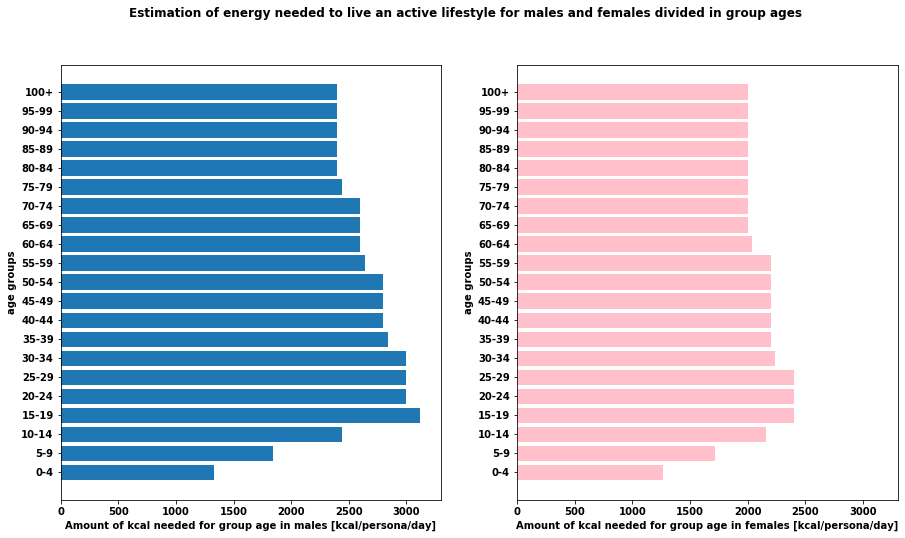

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].barh(male_calories.index, male_calories["input kcal"])
axes[1].barh(female_calories.index, female_calories["input kcal"],color="#ffc0cb")
axes[0].set_xlabel("Amount of kcal needed for group age in males [kcal/persona/day]")
fig.suptitle("Estimation of energy needed to live an active lifestyle for males and females divided in group ages")
axes[1].set_xlabel("Amount of kcal needed for group age in females [kcal/persona/day]")
axes[1].set_xlim(0, 3300)
axes[0].set_xlim(0, 3300)
axes[0].set_ylabel("age groups")
axes[1].set_ylabel("age groups");

As as we can see, in general, males need more calories than females.

### 2.2) How many people live in Africa?

#### 2.2.1) Preprocessing

In this second part of our analysis, we load the list of **African countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [33]:
with open (path_dict['african_countries_list'],'r') as af_c:
    af_countries = [line.rstrip() for line in af_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Africa. We will check the intersection with the list **af_countries**.

In [34]:
af_to_remove = list(set(af_countries) - set(food_supply_africa.columns.values))
print("List of countries for which no data is available: " + str(af_to_remove))

List of countries for which no data is available: ['Eritrea', 'Burundi', 'Somalia', 'Libya', 'Equatorial Guinea', 'Seychelles', 'RÃ©union', 'Democratic Republic of the Congo', 'Mauritius', 'Comoros', 'Western Sahara', 'Mayotte', 'Sao Tome and Principe', 'South Sudan', "CÃ´te d'Ivoire", 'Cabo Verde']


As expected, many countries were not present in the FAO Database. The countries to remove are the following: **Eritrea, Burundi, Comoros, Democratic Republic of the Congo, Equatorial Guinea, Libya, Seychelles, Western Sahara, South Sudan, and Somalia**. Furthermore, **Mayotte** and **Réunion** are French territory islands so they will be removed as well.

In [35]:
af_countries = [i for i in af_countries if not i in af_to_remove]
af_to_remove = list(set(af_countries)- set(food_supply_africa.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: []


Now we can proceed to load the **population data** and clean it

In [36]:
#loading datasets
pop_male = pd.read_excel(path_dict['population_age_male'], sheet_name="ESTIMATES")
pop_female = pd.read_excel(path_dict['population_age_female'], sheet_name="ESTIMATES")

The function `clean_pop_df` takes care to do all the needed cleaning. What it does is removing all the not necessary columns and retaining just the rows of the needed countries. Then multiplies tha value by 1000 (Since the population data is per 1000 people, all entries are multiplied by the same factor (1000) to return to the real value).

In [37]:
pop_male_africa = clean_pop_df(pop_male, af_countries)
pop_female_africa = clean_pop_df(pop_female, af_countries)

**World Population Database** (United Nation) is now loaded and cleaned. This preprocessing is necessary in order to sort things out for next more complex steps.  

Let's have a look at the final version of male population data grouped by age:

In [38]:
pop_male_africa.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
420,Djibouti,1950,6128,4593,3828,3247,2727,2266,1873,1538,...,589,422,277,160,74,24,7,0,0,0
421,Djibouti,1955,5556,5527,4487,3773,3168,2639,2186,1800,...,696,506,337,198,94,33,7,0,0,0
422,Djibouti,1960,7201,5360,5668,4640,3867,3218,2672,2203,...,868,631,428,256,126,46,11,0,0,0
423,Djibouti,1965,10888,7814,6324,6545,5316,4389,3642,3006,...,1191,872,591,358,179,71,16,2,0,0
424,Djibouti,1970,15553,11828,9094,7514,7519,6072,4994,4120,...,1646,1208,826,503,259,102,24,3,0,0


#### 2.2.2) Interpolating the data on African population

In this context, the population dataframe for males **pop_male** and for females **pop_female** contains measurements of population censi, for years from 1950 to 2020 with a frequency of **5 years**. Next, data is interpolated in order to obtain values for intermediate years. 

For our interpolation method to work, we need to know if the population evolution in these intervals of 5 years is linear. In order to do so, we need to visualize the growth of the population for a group of countries (plotting all of them would be confusing). So we select **3 countries** randomly and plot a simple animation of the growth over time.  
*Note*: the code below is used to generate the HTML animation. To see it without running the notebook **click on [this link](https://manuleo.github.io/mADAm-2019/african_cal_diff_animation.html)**

In [ ]:
# # Selecting countries

# countryrand = []
# n_countries = 3
# for i in range(0, n_countries):
#     countryrand.append(random.choice(pop_male_africa.country.drop_duplicates().values))

# fig = plt.figure()
# animator = animation.FuncAnimation(fig, timeline_country_gender, frames=(range(1950, 2025, 5)),\
#                                    fargs = (pop_male_africa, pop_female_africa, "30-34", countryrand), repeat=False)
# #HTML(animator.to_jshtml())

# with open(path_dict['african_pop_growth'], "w") as f:
#     print(animator.to_html5_video(), file=f)

The animation show an almost linear growth for the 3 countries considered (with their respective scale), so we can continue with the interpolation

Now we can apply our function `interpolate_years`, a simple linear interpolation, in order to obtain a frequency of **1 year**.

In [39]:
pop_male_africa = interpolate_years(pop_male_africa, 1950, 2020)
pop_female_africa = interpolate_years(pop_female_africa, 1950, 2020)

Let's see how the new dataframes for males and females population look like:

In [40]:
pop_male_africa.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,6128.0,4593.0,3828.0,3247.0,2727.0,2266.0,1873.0,1538.0,...,589.0,422.0,277.0,160.0,74.0,24.0,7.0,0.0,0.0,0.0
1,Djibouti,1951,6013.6,4779.8,3959.8,3352.2,2815.2,2340.6,1935.6,1590.4,...,610.4,438.8,289.0,167.6,78.0,25.8,7.0,0.0,0.0,0.0
2,Djibouti,1952,5899.2,4966.6,4091.6,3457.4,2903.4,2415.2,1998.2,1642.8,...,631.8,455.6,301.0,175.2,82.0,27.6,7.0,0.0,0.0,0.0
3,Djibouti,1953,5784.8,5153.4,4223.4,3562.6,2991.6,2489.8,2060.8,1695.2,...,653.2,472.4,313.0,182.8,86.0,29.4,7.0,0.0,0.0,0.0
4,Djibouti,1954,5670.4,5340.2,4355.2,3667.8,3079.8,2564.4,2123.4,1747.6,...,674.6,489.2,325.0,190.4,90.0,31.2,7.0,0.0,0.0,0.0


In [41]:
pop_female_africa.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,6065.0,4583.0,3819.0,3238.0,2736.0,2295.0,1911.0,1574.0,...,655.0,487.0,334.0,202.0,100.0,34.0,11.0,2.0,0.0,0.0
1,Djibouti,1951,5948.6,4764.2,3949.6,3342.8,2824.4,2369.8,1973.8,1627.2,...,679.0,505.8,347.6,211.2,105.4,37.0,11.0,2.0,0.0,0.0
2,Djibouti,1952,5832.2,4945.4,4080.2,3447.6,2912.8,2444.6,2036.6,1680.4,...,703.0,524.6,361.2,220.4,110.8,40.0,11.0,2.0,0.0,0.0
3,Djibouti,1953,5715.8,5126.6,4210.8,3552.4,3001.2,2519.4,2099.4,1733.6,...,727.0,543.4,374.8,229.6,116.2,43.0,11.0,2.0,0.0,0.0
4,Djibouti,1954,5599.4,5307.8,4341.4,3657.2,3089.6,2594.2,2162.2,1786.8,...,751.0,562.2,388.4,238.8,121.6,46.0,11.0,2.0,0.0,0.0


#### 2.2.3) Computing the total African population

Lastly, we will compute the total population per year. This new dataframe **pop_tot** will be useful for the next section of our analysis. `obtain_total_pop` does just this, combining the population in *pop_male_africa* and *pop_female_africa*.

In [42]:
pop_tot_africa = obtain_total_pop(pop_male_africa, pop_female_africa)

For the next analysis we will need to match this data with the `food_balance_africa`. We proceed to give to our population data the same shape as the other datasets by using the function `reshape_pop_dataframe`. 

In [43]:
pop_tot_africa = reshape_pop_dataframe(pop_tot_africa)

In [44]:
pop_tot_africa.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Algeria,8872250.0,9052656.0,9233062.0,9413468.0,9593874.0,9774280.0,10030996.8,10287713.6,10544430.4,10801147.2,...,36727564.8,37477678.6,38227792.4,38977906.2,39728020.0,40552624.6,41377229.2,42201833.8,43026438.4,43851043.0
Angola,4548021.0,4647067.0,4746113.0,4845159.0,4944205.0,5043251.0,5125588.4,5207925.8,5290263.2,5372600.6,...,24261873.6,25167500.2,26073126.8,26978753.4,27884380.0,28880757.6,29877135.2,30873512.8,31869890.4,32866268.0
Benin,2255222.0,2264896.0,2274570.0,2284244.0,2293918.0,2303592.0,2329197.0,2354802.0,2380407.0,2406012.0,...,9474595.6,9749937.2,10025278.8,10300620.4,10575962.0,10885409.2,11194856.4,11504303.6,11813750.8,12123198.0
Botswana,412541.0,422703.4,432865.8,443028.2,453190.6,463353.0,471229.0,479105.0,486981.0,494857.0,...,2013828.0,2040550.0,2067272.0,2093994.0,2120716.0,2166897.8,2213079.6,2259261.4,2305443.2,2351625.0
Burkina Faso,4284455.0,4330995.0,4377535.0,4424075.0,4470615.0,4517155.0,4579581.8,4642008.6,4704435.4,4766862.2,...,16106292.0,16607373.0,17108454.0,17609535.0,18110616.0,18669148.4,19227680.8,19786213.2,20344745.6,20903278.0


### 2.3) Estimantion of ideal human food demand in Africa 

Now we multiply each column of the population data for each matching `age_group` in the calories table (which is squeezed to enable multiplication, similar to transposing rows/columns of the dataset).  All of this is done in `get_calories_need`  
We obtain two datasets: `male_cal_need_africa` and `female_cal_need_africa` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [45]:
male_cal_need_africa = get_calories_need(pop_male_africa, male_calories)
male_cal_need_africa.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,8.170667e+06,8451120.0,9340320.0,10130640.0,8181000.0,6798000.0,5619000.0,4367920.0,...,1554960.0,1097200.0,720200.0,416000.0,180560.0,57600.0,16800.0,0.0,0.0,0.0
1,Djibouti,1951,8.018133e+06,8794832.0,9661912.0,10458864.0,8445600.0,7021800.0,5806800.0,4516736.0,...,1611456.0,1140880.0,751400.0,435760.0,190320.0,61920.0,16800.0,0.0,0.0,0.0
2,Djibouti,1952,7.865600e+06,9138544.0,9983504.0,10787088.0,8710200.0,7245600.0,5994600.0,4665552.0,...,1667952.0,1184560.0,782600.0,455520.0,200080.0,66240.0,16800.0,0.0,0.0,0.0
3,Djibouti,1953,7.713067e+06,9482256.0,10305096.0,11115312.0,8974800.0,7469400.0,6182400.0,4814368.0,...,1724448.0,1228240.0,813800.0,475280.0,209840.0,70560.0,16800.0,0.0,0.0,0.0
4,Djibouti,1954,7.560533e+06,9825968.0,10626688.0,11443536.0,9239400.0,7693200.0,6370200.0,4963184.0,...,1780944.0,1271920.0,845000.0,495040.0,219600.0,74880.0,16800.0,0.0,0.0,0.0


In [46]:
#total calories female
female_cal_need_africa = get_calories_need(pop_female_africa, female_calories)
female_cal_need_africa.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,7.682333e+06,7882760.0,8249040.0,7771200.0,6566400.0,5508000.0,4280640.0,3462800.0,...,1441000.0,993480.0,668000.0,404000.0,200000.0,68000.0,22000.0,4000.0,0.0,0.0
1,Djibouti,1951,7.534893e+06,8194424.0,8531136.0,8022720.0,6778560.0,5687520.0,4421312.0,3579840.0,...,1493800.0,1031832.0,695200.0,422400.0,210800.0,74000.0,22000.0,4000.0,0.0,0.0
2,Djibouti,1952,7.387453e+06,8506088.0,8813232.0,8274240.0,6990720.0,5867040.0,4561984.0,3696880.0,...,1546600.0,1070184.0,722400.0,440800.0,221600.0,80000.0,22000.0,4000.0,0.0,0.0
3,Djibouti,1953,7.240013e+06,8817752.0,9095328.0,8525760.0,7202880.0,6046560.0,4702656.0,3813920.0,...,1599400.0,1108536.0,749600.0,459200.0,232400.0,86000.0,22000.0,4000.0,0.0,0.0
4,Djibouti,1954,7.092573e+06,9129416.0,9377424.0,8777280.0,7415040.0,6226080.0,4843328.0,3930960.0,...,1652200.0,1146888.0,776800.0,477600.0,243200.0,92000.0,22000.0,4000.0,0.0,0.0


Once we have the calories needed for both genders, we can aggregate the total caloric need of african countries into `total_cal_need_africa`. The function `obtain_total_cal_need` does just this, returning a dataframe with the calories needed for all the population of a country in a year, in the unit **kcal/year**.

In [47]:
total_cal_need_africa = obtain_total_cal_need(male_cal_need_africa, female_cal_need_africa)

Let's take a look at total calories dataframe **total_cal**:

In [48]:
total_cal_need_africa.sort_values(by="Calories", ascending=False).head()

,country,year,Calories
2342,Nigeria,2020,1.679755e+14
2341,Nigeria,2019,1.637743e+14
2340,Nigeria,2018,1.595730e+14
2339,Nigeria,2017,1.553718e+14
2338,Nigeria,2016,1.511706e+14


For the sake of consistency, we will now reshape our dataframe `total_cal` into a new one `total_cal_final` according to the same schema seen for `food_supply_africa`.

In [49]:
total_cal_need_africa = reshape_calories_df(total_cal_need_africa)

Drawing a sample of the final shaped dataframe total calories `total_cal_need_africa`:

In [50]:
total_cal_need_africa.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Algeria,7.290425e+12,7.412354e+12,7.534284e+12,7.656213e+12,7.778143e+12,7.900072e+12,8.092341e+12,8.284610e+12,8.476879e+12,8.669149e+12,...,3.150748e+13,3.205546e+13,3.260345e+13,3.315144e+13,3.369942e+13,3.433776e+13,3.497610e+13,3.561444e+13,3.625278e+13,3.689112e+13
Angola,3.721975e+12,3.797306e+12,3.872637e+12,3.947968e+12,4.023299e+12,4.098630e+12,4.159526e+12,4.220422e+12,4.281318e+12,4.342214e+12,...,1.941009e+13,2.013902e+13,2.086796e+13,2.159689e+13,2.232582e+13,2.315305e+13,2.398027e+13,2.480750e+13,2.563473e+13,2.646195e+13
Benin,1.851458e+12,1.858390e+12,1.865323e+12,1.872255e+12,1.879187e+12,1.886119e+12,1.905149e+12,1.924180e+12,1.943210e+12,1.962241e+12,...,7.691320e+12,7.921509e+12,8.151697e+12,8.381886e+12,8.612074e+12,8.874543e+12,9.137011e+12,9.399479e+12,9.661947e+12,9.924415e+12
Botswana,3.377080e+11,3.450761e+11,3.524442e+11,3.598122e+11,3.671803e+11,3.745484e+11,3.799093e+11,3.852703e+11,3.906313e+11,3.959923e+11,...,1.688976e+12,1.709664e+12,1.730351e+12,1.751039e+12,1.771726e+12,1.812568e+12,1.853409e+12,1.894250e+12,1.935091e+12,1.975932e+12
Burkina Faso,3.538834e+12,3.574675e+12,3.610516e+12,3.646357e+12,3.682198e+12,3.718039e+12,3.765608e+12,3.813178e+12,3.860748e+12,3.908317e+12,...,1.296491e+13,1.338135e+13,1.379779e+13,1.421422e+13,1.463066e+13,1.510462e+13,1.557857e+13,1.605253e+13,1.652648e+13,1.700044e+13


Let's go on with a interactive visualization of the data in order to understand the trend over countries. The following map is based on data for **2020**.

## 3) Which countries are in food deficit?
Next, an interesting comparison is introduced between the two dataframes we have obtained in the fist two parts of our analysis. More specifically, the analysis will take into account the total population dataframe `pop_tot_africa` and the `food_supply_africa`. With regard to the FAO Dataframe of food supply, we will need to transform the unit in **kcal/year** in order to compare results appropriately.

The function `obtain_difference` takes into account our dataframes to compute which countris have enough caloric food supply to actually meet their needs. 

In [51]:
caloric_difference_africa = obtain_difference(pop_tot_africa, food_supply_africa, total_cal_need_africa)
caloric_difference_africa.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Algeria,-573.589919,-620.801820,-659.153014,-644.633318,-591.233516,-612.982117,-538.630181,-481.186136,-483.657494,-515.050972,...,866.671209,928.653501,959.361778,998.680650,1009.590805,1041.856405,1058.409442,1066.538096,1083.352529,1086.631007
Angola,-413.161895,-391.881557,-357.607490,-348.339486,-333.077345,-320.591047,-290.100518,-355.605811,-266.106978,-247.604067,...,215.152631,191.672527,280.225775,186.029318,294.259093,203.038770,292.560777,210.272579,277.137533,214.003164
Benin,-492.836248,-467.466793,-519.203353,-550.041004,-403.975119,-409.528255,-378.181242,-273.928090,-335.763279,-392.681714,...,373.935633,384.061159,391.289648,386.664138,392.847960,387.777835,390.545646,388.001273,387.055618,384.440686
Botswana,-208.233159,-272.356799,-206.603106,-174.964398,-168.433620,-225.305819,-161.230054,-118.202804,-156.220859,-133.281287,...,-24.779281,46.535339,32.790121,49.163878,88.124217,68.644236,103.269109,65.282088,99.284178,67.992986
Burkina Faso,-915.448084,-930.741495,-784.109191,-678.548155,-660.055530,-668.265460,-638.569119,-620.961863,-616.439348,-671.997508,...,458.632137,499.472919,510.440182,517.817483,514.063968,518.852721,521.753299,516.341587,517.861824,517.405554


### Visualizing the data

Let's start by doing a simple barplot of the deficit per persona/year in each country. As our main point of interest is the present, we will start with a graph showing this year sitution:

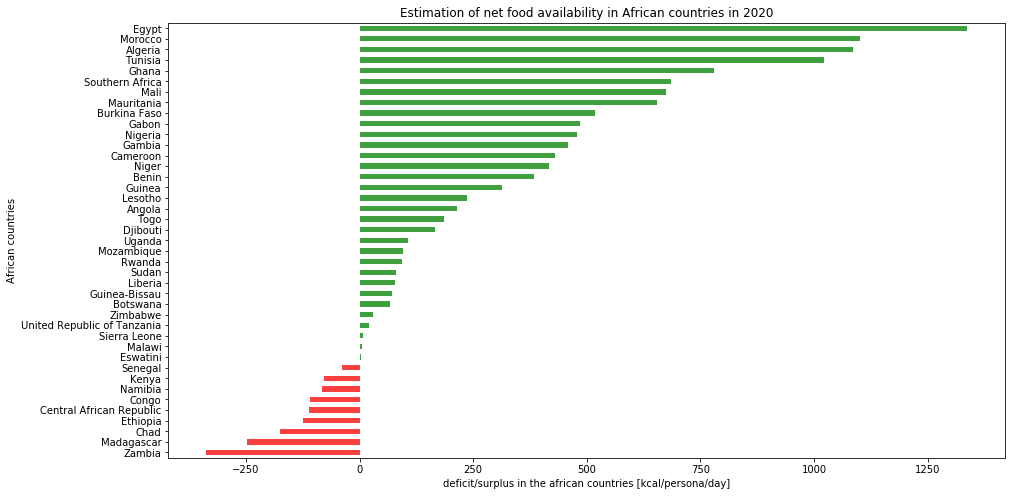

In [52]:
caloric_difference_africa_sorted = caloric_difference_africa[2020].sort_values()
p = caloric_difference_africa_sorted.plot(kind='barh', color=(caloric_difference_africa_sorted > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("deficit/surplus in the african countries [kcal/persona/day]")
p.set_ylabel("African countries")
plt.title('Estimation of net food availability in African countries in 2020' );

For a better visualization, is convenient to see the **evolution of the kcal demand** for all the interested year. By using the `draw_demand_bar` we wil plot the information for every year, combined with an animation to move back and forth in the time.  
*Note*: the code below is used to generate the HTML animation. As it's impossible to show it without running the notebook, we saved it as a HTML and included the link in the markdown.  
**To see the animation, click on [this link](https://manuleo.github.io/mADAm-2019/african_cal_diff_animation.html)**

In [ ]:
# # # Code to generate the animation


# fig = plt.figure()
# animator = animation.FuncAnimation(fig, draw_demand_bar, frames=range(1961, 2021),\
#                                    fargs=(caloric_difference_africa, ),
#                                       repeat=False);
# #HTML(animator.to_jshtml())
# with open(path_dict['african_demand_anim'], "w") as f:
#     print(animator.to_html5_video(), file=f)

Let's now move on our typical map visualization:

In [92]:
legend_name = "Estimation of kcal/persona/day deficit"
for year in range(1970,2030,10):
    bins = [min(caloric_difference_africa[year]), 0, 200, 450, max(caloric_difference_africa[year])]
    african_kcal_need_map = plot_map(caloric_difference_africa, path_dict['geoworld_json'], \
    african_country_kv, year, "RdYlGn", legend_name, legend_name, path_dict['african_kcal_need'] + str(year) + ".html", bins)
african_kcal_need_map

# Determination of European countries with food surplus

## 1) How much human food resources are available for European countries?

### 1.1) Preprocessing

To answer this important question, we will need to import data from the **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect to European countries only. 

In [95]:
food_balance_europe = pd.read_csv(path_dict['food_balance_europe'],encoding='latin-1', low_memory=False);

European countries will be analysed following the same strategy we used for African countries in order to be consistent also in the way by which we assess whethere countries are in deficit or are in surplus. To start off, we will:
- **remove** all the columns with title **"Y----F"**.
- **replace** all the **NAN** values with **0** as Item was not available.

In [96]:
food_balance_europe = clean_Fs_and_years(food_balance_europe)
food_balance_europe = food_balance_europe.fillna(0);

The third step to complete **the cleaning** of food_balance_europe consists on adapting names of countries in order to have consistency along our different dataframes.

The easiest of these changes that we observe in our dataframe is **The former Yugoslav Republic of Macedonia** should become **North Macedonia**.

In [97]:
food_balance_europe = replace_names_of_countries(food_balance_europe, [("The former Yugoslav Republic of Macedonia", "North Macedonia")])

Our Dataframe looks like this:

In [98]:
food_balance_europe.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,3,Albania,2501,Population,511,Total Population - Both sexes,1000 persons,1669.0,1719.0,1771.0,...,3216.0,3196.0,3180.0,3166.0,3157.0,3151.0,3150.0,3154.0,3162.0,3173.0
1,3,Albania,2511,Wheat and products,5511,Production,1000 tonnes,98.0,146.0,62.0,...,253.0,260.0,231.0,250.0,335.0,333.0,295.0,293.0,300.0,294.0
2,3,Albania,2511,Wheat and products,5611,Import Quantity,1000 tonnes,182.0,89.0,110.0,...,465.0,417.0,414.0,406.0,355.0,343.0,362.0,389.0,377.0,360.0
3,3,Albania,2511,Wheat and products,5072,Stock Variation,1000 tonnes,-52.0,-4.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,Albania,2511,Wheat and products,5911,Export Quantity,1000 tonnes,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,4.0,4.0


Given the European countries analysis, and since the structure of this dataset is equivalent to that one, we can again obtain the pairs **(Item Code, 2901) and (Element Code, 664)** for our Europe analysis.

In [99]:
food_supply_europe = obtain_supply(food_balance_europe)

We can now group by **Area** and see the supplies derived from each item available in countries for each particular year.

In [100]:
food_supply_europe = food_supply_europe.set_index("Area")
food_supply_europe.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,
Albania,2223.0,2242.0,2156.0,2270.0,2254.0,2254.0,2262.0,2343.0,2404.0,2415.0,...,2792.0,2874.0,2855.0,2860.0,2947.0,2993.0,3076.0,3132.0,3184.0,3193.0
Austria,3191.0,3193.0,3248.0,3270.0,3220.0,3232.0,3194.0,3221.0,3153.0,3217.0,...,3606.0,3640.0,3719.0,3737.0,3717.0,3723.0,3724.0,3735.0,3739.0,3768.0
Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2901.0,2987.0,3084.0,3186.0,3200.0,3126.0,3196.0,3400.0,3400.0,3250.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3722.0,3716.0,3716.0,3713.0,3702.0,3697.0,3707.0,3720.0,3715.0,3733.0
Belgium-Luxembourg,2923.0,2908.0,3007.0,3061.0,2966.0,3067.0,3088.0,3032.0,3156.0,3068.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [101]:
food_supply_europe = food_supply_europe.transpose();

In [102]:
#converting the year from string to int
food_supply_europe.index = food_supply_europe.index.astype(int)

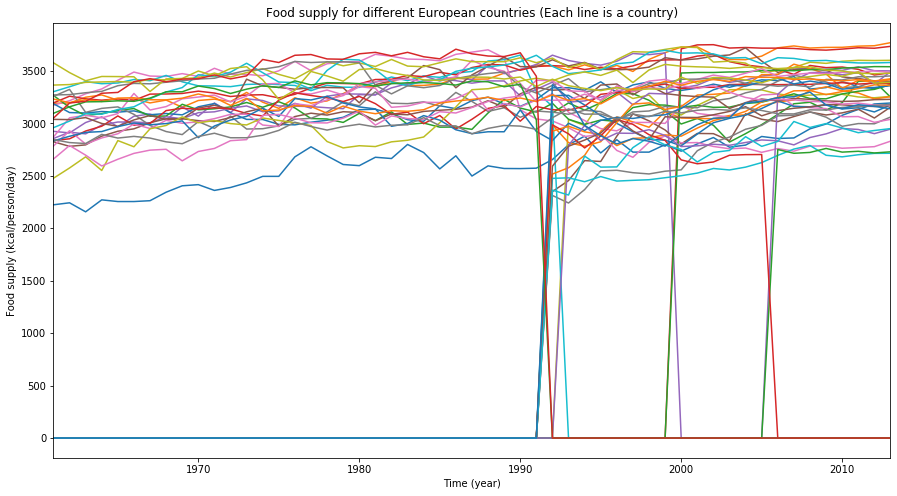

In [103]:
timeline_supply(food_supply_europe, "European")

We can observe a similar situation in this graph as we did in the African countries analysis. As such, we can assume that some countries may have changed names or maybe some other situations occured, which caused countries data to stop being recorded/collected. 

Let's then see which countries have zeros in the values for food supplies.

In [104]:
food_supply_europe.columns.values[(food_supply_europe == 0).any()]

array(['Belarus', 'Belgium', 'Belgium-Luxembourg',
       'Bosnia and Herzegovina', 'Croatia', 'Czechia', 'Czechoslovakia',
       'Estonia', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro',
       'Republic of Moldova', 'Russian Federation', 'Serbia',
       'Serbia and Montenegro', 'Slovakia', 'Slovenia', 'North Macedonia',
       'Ukraine', 'USSR', 'Yugoslav SFR'], dtype=object)

Respecting the cronology, we observe that there were some countries on which data stopped being collected, as well as others from which data started being collected after the initial collection year of 1950. After some search online on these countries, we actually find out that:
- **USSR** (Union of Soviet Socialist Republics) was a union of a lot of countries, some of which were not even located in Europe. The Union was dissolved in 26 December 1991, and so the countries **Belarus**, **Ukraine**, **Estonia**, **Republic of Moldova**, **Russian Federation**, **Latvia**, **Lithuania** are the europeans countries that became independent in Europe.
- **Yugoslav SFR** was made up of the countries that became **Bosnia and Herzegovina**, **Croatia**, **Serbia and Montenegro**, **North Macedonia**, **Slovenia**, all of which obtained their independence between 25 June 1991 - 27 April 1992
- **Czechoslovakia** was dissoluted in 1 January 1993, after a period called The Velvet Revolution (because of the peaceful ways), and became the two countries **Czechia** and **Slovakia**
- **Serbia and Montenegro** separated themselves in 2006, breaking up the last union still recognized as a sucessor of Yougoslavia
- **Belgium-Luxembourg** (2003) does not have a main reason to exist, as there is no major event happening in 2003 that would justify the mixing of the two countries. Our understanding lead us to believe this was probably just a grouping created in FAO when collecting the data from the two countries.

Let's then take care of all these cases

In [105]:
countries_to_merge = {'USSR': ['Belarus', 'Ukraine', 'Estonia', 'Republic of Moldova', 'Russian Federation', 'Latvia', 'Lithuania'], 
                         'Yugoslav SFR': ['Bosnia and Herzegovina', 'Croatia', 'Serbia and Montenegro', 'North Macedonia', 'Slovenia'],
                         'Czechoslovakia': ['Czechia', 'Slovakia'],
                         'Serbia and Montenegro': ['Serbia', 'Montenegro'],
                         'Belgium-Luxembourg': ['Luxembourg', 'Belgium']}
food_supply_europe = merge_countries(food_supply_europe, countries_to_merge)

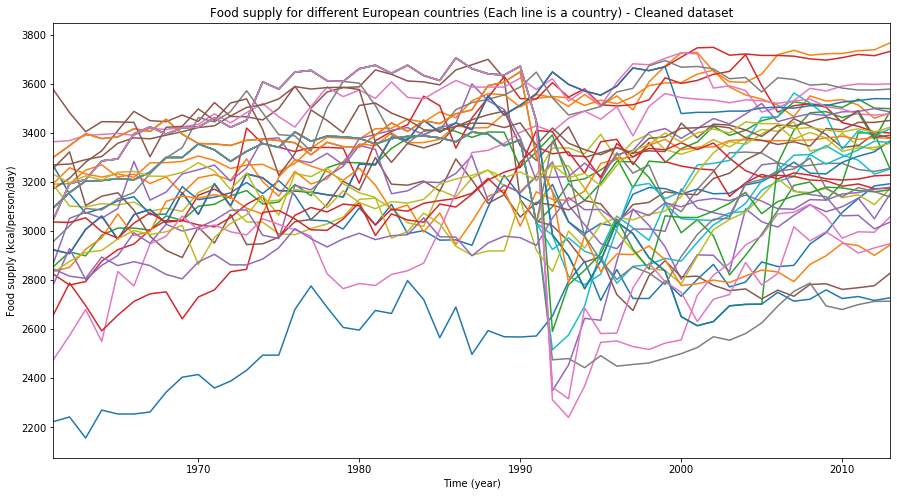

In [106]:
timeline_supply(food_supply_europe, "European", " - Cleaned dataset")

We observe a drop in the *food supply* from most countries that came from the former USSR, which we find to be interesting. While it might not be the case for all of these countries, some of them are vey poor and as such, when separated from the world power that was the USSR, their ability to provide and produce for themselves may have dropped significantly, which is coherent with what we observe. As such, we continue our analysis with these values.

### 1.2) Interpolation

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios.

In [107]:
food_supply_europe = prepare_future(food_supply_europe, 2014, 2020)

In [108]:
food_supply_europe = predict_future(food_supply_europe, path_dict['europe_supply_rnn'])

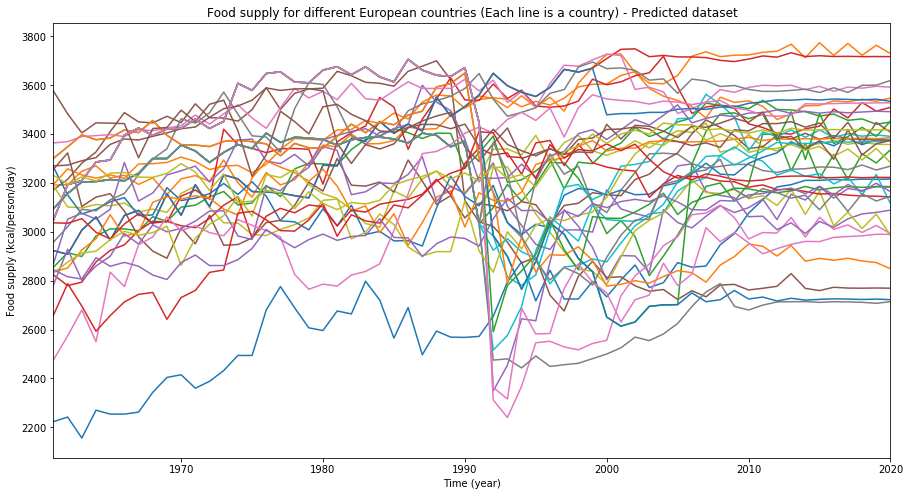

In [109]:
timeline_supply(food_supply_europe, "European", " - Predicted dataset")

Visualizing our results with a interactive heatmap:

In [110]:
european_country_codes = ["ALB","AUT","BLR","BEL","BIH","BGR","HRV","CZE","DNK","EST","FIN","FRA","DEU","GRC","HUN","ISL","IRL",
                          "ITA","LVA","LTU","LUX","MALTAMISSING","MNE","NLD","NOR","POL","PRT","MDA","ROU","RUS","SRB","SWK",
                          "SVN","ESP","SWE","CHE","MKD","UKR","GBR"]
european_country_names = food_supply_europe.T.index.values


european_country_kv = pd.DataFrame({'codes': european_country_codes,
                                    'names': european_country_names
                                    })

geojson_europe = geojson_world[geojson_world.id.isin(european_country_codes)]
geojson_europe.head()

,id,name,geometry
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
9,AUT,Austria,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."
12,BEL,Belgium,"POLYGON ((3.31497 51.34578, 4.04707 51.26726, ..."
16,BGR,Bulgaria,"POLYGON ((22.65715 44.23492, 22.94483 43.82379..."
18,BIH,Bosnia and Herzegovina,"POLYGON ((19.00549 44.86023, 19.36803 44.86300..."


We notice, after our manual analysis on the countries that **Malta** is not displayed in the json. Hence, we won't consider it for out analysis

In [111]:
food_supply_europe = food_supply_europe.drop(columns=["Malta"])

In [112]:
legend_name = "Food supply in Europe (kcal/person/day)"
for year in range(1970, 2030, 10):
    europe_supply_map = plot_map(food_supply_europe.T, path_dict['geoworld_json'], \
    european_country_kv, year, "Blues", legend_name, legend_name, path_dict['european_supply_map'] + str(year) + ".html", bins=9)
europe_supply_map

## 2) What is the ideal amount of kcal each European country needs?
Once again, we do a very similar analysis on European countries as we did for the African ones.

### 2.1) How many people live in Europe?

#### 2.1.1) Preprocessing

In this second part of our analysis, we load the list of **European countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [69]:
with open (path_dict["european_countries_list"],'r') as eu_c:
    eu_countries = [line.rstrip() for line in eu_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Europe. We will check the intersection with the list `eu_countries`.

In [70]:
eu_to_remove = list(set(eu_countries) - set(food_supply_europe.columns.values))
print("List of countries for which no data is available: " + str(eu_to_remove))

List of countries for which no data is available: ['Malta', 'Channel Islands']


Because there are less countries in Europe, and also because most European countries are part of ONU, we expected most countries to be present in both the FAO database and the population database. These **Channel Islands** are a small set of islands in the English Channel, and because they are so small, we can safely remove them from our scope of interest.

In [71]:
eu_countries = [i for i in eu_countries if not i in eu_to_remove]
eu_to_remove = list(set(eu_countries) - set(food_supply_europe.columns.values))
print("List of countries for which no data is available: " + str(eu_to_remove))

List of countries for which no data is available: []


We now obtain the population for each gender in all european countries.

In [72]:
pop_male_europe = clean_pop_df(pop_male, eu_countries)
pop_female_europe = clean_pop_df(pop_female, eu_countries)

Let's have a look at the final version of male population data grouped by age:

In [73]:
pop_male_europe.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
3135,Belarus,1950,333700,282651,395174,382562,361905,237761,150660,206475,...,138445,124045,99216,68726,41415,19537,7648,2113,365,35
3136,Belarus,1955,418684,315056,264730,374177,357223,337374,219617,136496,...,128674,111772,95381,70127,42393,19507,8196,2262,415,47
3137,Belarus,1960,491730,406036,305601,255607,360905,342271,323037,208441,...,150864,108601,89962,70827,45805,21818,8211,2371,420,50
3138,Belarus,1965,448162,482745,398975,299589,248620,350831,331524,311625,...,158297,130151,89304,68499,47682,24484,9262,2393,448,52
3139,Belarus,1970,368381,450207,485335,400660,299407,247750,348188,327625,...,147426,140703,110454,70311,47732,27537,10041,2554,418,51


#### 2.1.2) Interpolation

Similarly to the analysis performed on Africa, we once again interpolate the years with a frequency of **5 years** in *pop_male_europe*, to have a frequency of 1 year. Before doing so, we check again if the evolution in these 5 years intervals occurs in a linear manner.  
**_Note_: as usual, the animation is not visible in the notebook, click [here]()**

In [219]:
# # Selecting countries
# countryrand = []
# n_countries = 2
# for i in range(0, n_countries):
#     countryrand.append(random.choice(pop_male_europe.country.drop_duplicates().values))

# fig = plt.figure()
# animator = animation.FuncAnimation(fig, timeline_country_gender, frames=(range(1950, 2025, 5)),\
#                                    fargs = (pop_male_europe, pop_female_europe, "30-34", countryrand), repeat=False)
# #HTML(animator.to_jshtml())

# with open(path_dict['european_pop_growth'], "w") as f:
#     print(animator.to_html5_video(), file=f)

Even if the growth is not so linear as a whole as before, the animation clearly shows that it is linear inside each group of 5 year. As our interpolation works by interpolating on each of these groups, we can proceed with it

In [74]:
pop_male_europe = interpolate_years(pop_male_europe, 1950, 2020)
pop_female_europe = interpolate_years(pop_female_europe, 1950, 2020)

Let's see how the new dataframes for males and females population look like:

In [75]:
pop_male_europe.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,333700.0,282651.0,395174.0,382562.0,361905.0,237761.0,150660.0,206475.0,...,138445.0,124045.0,99216.0,68726.0,41415.0,19537.0,7648.0,2113.0,365.0,35.0
1,Belarus,1951,350696.8,289132.0,369085.2,380885.0,360968.6,257683.6,164451.4,192479.2,...,136490.8,121590.4,98449.0,69006.2,41610.6,19531.0,7757.6,2142.8,375.0,37.4
2,Belarus,1952,367693.6,295613.0,342996.4,379208.0,360032.2,277606.2,178242.8,178483.4,...,134536.6,119135.8,97682.0,69286.4,41806.2,19525.0,7867.2,2172.6,385.0,39.8
3,Belarus,1953,384690.4,302094.0,316907.6,377531.0,359095.8,297528.8,192034.2,164487.6,...,132582.4,116681.2,96915.0,69566.6,42001.8,19519.0,7976.8,2202.4,395.0,42.2
4,Belarus,1954,401687.2,308575.0,290818.8,375854.0,358159.4,317451.4,205825.6,150491.8,...,130628.2,114226.6,96148.0,69846.8,42197.4,19513.0,8086.4,2232.2,405.0,44.6


In [76]:
pop_female_europe.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,325456.0,287716.0,420006.0,403120.0,424672.0,338168.0,223359.0,326549.0,...,178569.0,183039.0,152746.0,119379.0,85709.0,39512.0,20284.0,7706.0,1924.0,293.0
1,Belarus,1951,338789.2,291637.0,389910.6,402225.4,415571.6,350871.6,242416.2,302527.8,...,179256.4,177849.8,153480.6,119761.2,85312.8,41588.0,19740.8,7352.0,1810.6,277.8
2,Belarus,1952,352122.4,295558.0,359815.2,401330.8,406471.2,363575.2,261473.4,278506.6,...,179943.8,172660.6,154215.2,120143.4,84916.6,43664.0,19197.6,6998.0,1697.2,262.6
3,Belarus,1953,365455.6,299479.0,329719.8,400436.2,397370.8,376278.8,280530.6,254485.4,...,180631.2,167471.4,154949.8,120525.6,84520.4,45740.0,18654.4,6644.0,1583.8,247.4
4,Belarus,1954,378788.8,303400.0,299624.4,399541.6,388270.4,388982.4,299587.8,230464.2,...,181318.6,162282.2,155684.4,120907.8,84124.2,47816.0,18111.2,6290.0,1470.4,232.2


#### 2.1.3) Computing total European population

Lastly, we will compute the total population per year. This new dataframe **pop_tot** will be useful for the next section of our analysis.

In [77]:
pop_tot_europe = obtain_total_pop(pop_male_europe, pop_female_europe)

For the next analysis we will need to match this data with the `food_balance_europe`. We proceed to give to our population data the same shape as the other dataset

In [78]:
pop_tot_europe = reshape_pop_dataframe(pop_tot_europe)

In [79]:
pop_tot_europe.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Albania,1263164.0,1294529.4,1325894.8,1357260.2,1388625.6,1419991.0,1463211.0,1506431.0,1549651.0,1592871.0,...,2936528.0,2925027.0,2913526.0,2902025.0,2890524.0,2887979.2,2885434.4,2882889.6,2880344.8,2877800.0
Austria,6936442.0,6939834.4,6943226.8,6946619.2,6950011.6,6953404.0,6976877.8,7000351.6,7023825.4,7047299.2,...,8463689.4,8517433.8,8571178.2,8624922.6,8678667.0,8744213.6,8809760.2,8875306.8,8940853.4,9006400.0
Belarus,7745004.0,7745446.2,7745888.4,7746330.6,7746772.8,7747215.0,7822748.2,7898281.4,7973814.6,8049347.8,...,9424345.6,9428115.2,9431884.8,9435654.4,9439424.0,9441403.4,9443382.8,9445362.2,9447341.6,9449321.0
Belgium,8637521.0,8687471.8,8737422.6,8787373.4,8837324.2,8887275.0,8943292.2,8999309.4,9055326.6,9111343.8,...,11008574.2,11078413.4,11148252.6,11218091.8,11287931.0,11348268.0,11408605.0,11468942.0,11529279.0,11589616.0
Bosnia and Herzegovina,2661296.0,2716296.8,2771297.6,2826298.4,2881299.2,2936300.0,2994172.8,3052045.6,3109918.4,3167791.2,...,3650254.8,3595031.6,3539808.4,3484585.2,3429362.0,3399652.6,3369943.2,3340233.8,3310524.4,3280815.0


## 3) Estimantion of ideal human food demand in Europe 

Now we multiply each column of the population data for each matching `age_group` in the calories table (that here we squeeze to allow the multiplication, similar to a transpose rows/columns of the dataset).  
We obtain two datasets: `male_cal_need_europe` and `female_cal_need_europe` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [80]:
#total calories male
male_cal_need_europe = get_calories_need(pop_male_europe, male_calories)
male_cal_need_europe.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,4.449333e+08,520077840.0,964224560.0,1.193593e+09,1.085715e+09,713283000.0,451980000.0,586389000.0,...,365494800.0,322517000.0,257961600.0,178687600.0,101052600.0,46888800.0,18355200.0,5071200.0,876000.0,84000.0
1,Belarus,1951,4.675957e+08,532002880.0,900567888.0,1.188361e+09,1.082906e+09,773050800.0,493354200.0,546640928.0,...,360335712.0,316135040.0,255967400.0,179416120.0,101529864.0,46874400.0,18618240.0,5142720.0,900000.0,89760.0
2,Belarus,1952,4.902581e+08,543927920.0,836911216.0,1.183129e+09,1.080097e+09,832818600.0,534728400.0,506892856.0,...,355176624.0,309753080.0,253973200.0,180144640.0,102007128.0,46860000.0,18881280.0,5214240.0,924000.0,95520.0
3,Belarus,1953,5.129205e+08,555852960.0,773254544.0,1.177897e+09,1.077287e+09,892586400.0,576102600.0,467144784.0,...,350017536.0,303371120.0,251979000.0,180873160.0,102484392.0,46845600.0,19144320.0,5285760.0,948000.0,101280.0
4,Belarus,1954,5.355829e+08,567778000.0,709597872.0,1.172664e+09,1.074478e+09,952354200.0,617476800.0,427396712.0,...,344858448.0,296989160.0,249984800.0,181601680.0,102961656.0,46831200.0,19407360.0,5357280.0,972000.0,107040.0


In [81]:
#total calories female
female_cal_need_europe = get_calories_need(pop_female_europe, female_calories)
female_cal_need_europe.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,4.122443e+08,494871520.0,907212960.0,967488000.0,1.019213e+09,811603200.0,500324160.0,718407800.0,...,392851800.0,373399560.0,305492000.0,238758000.0,171418000.0,79024000.0,40568000.0,15412000.0,3848000.0,586000.0
1,Belarus,1951,4.291330e+08,501615640.0,842206896.0,965340960.0,9.973718e+08,842091840.0,543012288.0,665561160.0,...,394364080.0,362813592.0,306961200.0,239522400.0,170625600.0,83176000.0,39481600.0,14704000.0,3621200.0,555600.0
2,Belarus,1952,4.460217e+08,508359760.0,777200832.0,963193920.0,9.755309e+08,872580480.0,585700416.0,612714520.0,...,395876360.0,352227624.0,308430400.0,240286800.0,169833200.0,87328000.0,38395200.0,13996000.0,3394400.0,525200.0
3,Belarus,1953,4.629104e+08,515103880.0,712194768.0,961046880.0,9.536899e+08,903069120.0,628388544.0,559867880.0,...,397388640.0,341641656.0,309899600.0,241051200.0,169040800.0,91480000.0,37308800.0,13288000.0,3167600.0,494800.0
4,Belarus,1954,4.797991e+08,521848000.0,647188704.0,958899840.0,9.318490e+08,933557760.0,671076672.0,507021240.0,...,398900920.0,331055688.0,311368800.0,241815600.0,168248400.0,95632000.0,36222400.0,12580000.0,2940800.0,464400.0


Once we have the calories needed for both gender, we can add them together easily to achieve total calories needed for **each country in each year**, and we collect them in the dataframe `total_cal_need_europe`. The unit is **kcal/year**. All of this is done by the `obtain_total_cal_need` function

In [82]:
total_cal_need_europe = obtain_total_cal_need(male_cal_need_europe, female_cal_need_europe)

Let's take a look at total calories dataframe **total_cal**:

In [83]:
total_cal_need_europe.sort_values(by="Calories", ascending=False).head()

,country,year,Calories
547,Russian Federation,2000,1.277543e+14
546,Russian Federation,1999,1.277413e+14
545,Russian Federation,1998,1.277284e+14
544,Russian Federation,1997,1.277154e+14
543,Russian Federation,1996,1.277024e+14


For the sake of consistency, we will now reshape our dataframe `total_cal_need_europe` according to the same schema seen for `food_supply_europe`.

In [84]:
total_cal_need_europe = reshape_calories_df(total_cal_need_europe)

Drawing a sample of the final shaped dataframe total calories `total_cal`:

In [85]:
total_cal_need_europe.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Albania,1.041791e+12,1.067157e+12,1.092523e+12,1.117889e+12,1.143255e+12,1.168621e+12,1.202214e+12,1.235807e+12,1.269400e+12,1.302993e+12,...,2.558970e+12,2.551603e+12,2.544237e+12,2.536870e+12,2.529503e+12,2.526050e+12,2.522597e+12,2.519144e+12,2.515691e+12,2.512237e+12
Austria,5.906169e+12,5.912127e+12,5.918085e+12,5.924043e+12,5.930001e+12,5.935959e+12,5.950704e+12,5.965449e+12,5.980194e+12,5.994939e+12,...,7.368272e+12,7.414042e+12,7.459812e+12,7.505582e+12,7.551352e+12,7.603258e+12,7.655163e+12,7.707068e+12,7.758973e+12,7.810878e+12
Belarus,6.581842e+12,6.573869e+12,6.565896e+12,6.557924e+12,6.549951e+12,6.541978e+12,6.585445e+12,6.628913e+12,6.672380e+12,6.715847e+12,...,8.184568e+12,8.171641e+12,8.158714e+12,8.145787e+12,8.132860e+12,8.125860e+12,8.118860e+12,8.111861e+12,8.104861e+12,8.097861e+12
Belgium,7.440138e+12,7.475404e+12,7.510669e+12,7.545935e+12,7.581201e+12,7.616467e+12,7.656335e+12,7.696202e+12,7.736070e+12,7.775938e+12,...,9.508244e+12,9.565091e+12,9.621938e+12,9.678785e+12,9.735632e+12,9.787514e+12,9.839396e+12,9.891278e+12,9.943160e+12,9.995042e+12
Bosnia and Herzegovina,2.207555e+12,2.252332e+12,2.297108e+12,2.341885e+12,2.386662e+12,2.431439e+12,2.479545e+12,2.527652e+12,2.575759e+12,2.623865e+12,...,3.196515e+12,3.144872e+12,3.093230e+12,3.041587e+12,2.989945e+12,2.963127e+12,2.936309e+12,2.909492e+12,2.882674e+12,2.855856e+12


We can proceed to plot the results inside a map visualization. The most interesting one is as usual the 2020, but analyzing also the pat years is important to understand how the trend changed.

In [113]:
for year in range(1970,2030,10):
    legend_name = "Estimation of kcal/year [10^11 kcal/year]"
    europe_kcal_est_map = plot_map(total_cal_need_europe.divide(10**11), path_dict['geoworld_json'], \
    european_country_kv, year, "YlGn", legend_name, legend_name, path_dict['european_estimation_kcal'] + str(year) + ".html", bins=9)
europe_kcal_est_map

## 3) Which countries have more than they need? 
In this Europe analysis, we flip the scope of our analysis completely. While in the case of Africa, we want to know which countries need most help (as in, are not producing enough to healthily survive), in Europe we want to find out which countries are producing more food internally than what they need. The point of this analysis is to find out who could help the African countries in need, by giving away some of their production, while still keeping at least a minimum to be healthy.

As with the African analysis, this analysis will take into account the total population dataframe `pop_tot` and the `food_supply_europe`. As regards the Fao Dataframe of food supply, we will need to transform the unit in **kcal/year** in order to compare results appropriately.

In [86]:
caloric_difference_europe = obtain_difference(pop_tot_europe, food_supply_europe, total_cal_need_europe)

In [87]:
caloric_difference_europe.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Albania,-13.834758,6.437203,-78.364674,36.765861,21.834368,17.419790,21.230166,98.248729,155.460337,162.851283,...,744.528672,794.041235,800.534160,815.804774,812.927833,818.292383,817.404589,821.619756,821.669430,824.708041
Austria,865.618730,870.779595,928.899367,953.978842,907.018796,919.030973,881.043010,908.054910,840.066677,904.078311,...,1349.864434,1354.192008,1383.515474,1328.758610,1390.383215,1339.989372,1390.463523,1343.677415,1386.151286,1353.341990
Belarus,815.470694,877.200747,923.935723,925.675488,933.419914,921.544550,945.798567,999.178346,992.680403,1041.301381,...,1020.686503,1025.394254,880.098242,996.816638,857.158851,958.721120,859.469478,966.582382,931.484184,988.133970
Belgium,588.233931,574.260475,674.274851,729.277274,635.267953,734.632818,754.010615,696.401193,818.804401,729.220090,...,1353.664146,1349.523251,1368.371593,1353.634612,1357.850225,1354.710149,1355.474792,1354.426316,1354.660523,1354.457022
Bosnia and Herzegovina,777.060508,918.659699,933.346142,1007.115164,1012.962422,1111.095960,1136.325436,1102.647323,1125.058265,1124.555066,...,734.831924,653.334435,759.915028,738.663968,795.658111,749.993127,789.841469,782.711656,800.878745,800.331316


In [88]:
caloric_difference_europe[caloric_difference_europe[2020].values < 0].index

Index([], dtype='object')

When running the exact same analysis on European countries as we did in African ones, it's interesting to observe that in Europe, no country at all is producing less than they actually need. As such all European countries are actually producing **more** than they need to be healthy, and should in theory be able to solve the hunger issue in Africa.  

### Visualizing the data

We can now proceed to the same visualization we did before, this time with the scope too see if in Europe **to visualize the 2020 situation and to see if there has been a deficit of kcal over the past years**

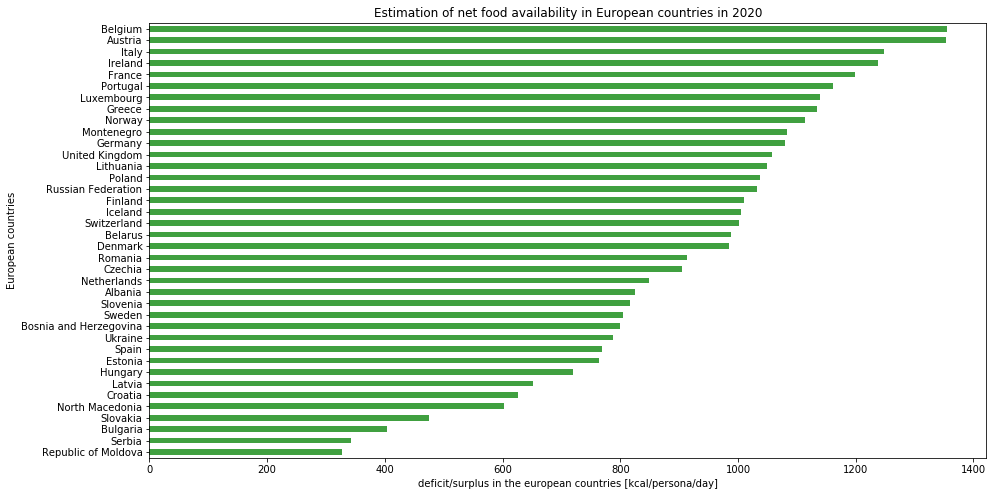

In [161]:
caloric_difference_europe_sorted = caloric_difference_europe[2020].sort_values()
p = caloric_difference_europe_sorted.plot(kind='barh', color=(caloric_difference_europe_sorted > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("deficit/surplus in the european countries [kcal/persona/day]")
p.set_ylabel("European countries")
plt.title('Estimation of net food availability in European countries in 2020' );

As already noticed before, european countries present a very high surplus of kcal needed. We can now plot the animation we used before to see the situation over the past years and see if Europe had deficits:

In [ ]:
# fig = plt.figure()
# animator = animation.FuncAnimation(fig, draw_demand_bar, frames=range(1961, 2021),\
#                                    fargs=(caloric_difference_europe, ),
#                                       repeat=False);
# #HTML(animator.to_jshtml())
# with open(path_dict['european_demand_anim'], "w") as f:
#     print(animator.to_html5_video(), file=f)

As we can see, the **Europe lives in a high wealth situation** since 1961. Over the past 50 years only in three years some countries presented a really small deficit in kcal:
- Albania in 1961 and 1963
- Moldova, Macedonia, Croazia (countries divided from the USSR), directly after their off-spring (this situation already emerged during the food supply analysis)

Finally, we draw a map of the European situation. Year **2020** is as usual the most important one, especially for the Europe, as we are interested on their actual surplus for the following of our analysis and because there has been basically no dramatical changing over the last 50 years.

In [116]:
legend_name = "Estimation of kcal/persona/day surplus"
for year in range(1970,2030,10):
    europe_kcal_surplus_map = plot_map(caloric_difference_europe, path_dict['geoworld_json'], \
    european_country_kv, year, "Greens", legend_name, legend_name, path_dict['european_kcal_surplus'] + str(year) + ".html", bins=8)
europe_kcal_surplus_map

With the information we gathered so far, we can proceed to a **comparison between Africa and Europe**, to move then to an analysis on which European countries should help African countries

# Which European countries can help Africa?

We have easily noticed that in Europe, every country has more food than they need to healthily survive. We will now show a map that shows this difference more noticeably.

In [138]:
afr_eu_country_codes = ["ALB","AUT","BLR","BEL","BIH","BGR","HRV","CZE","DNK","EST","FIN","FRA","DEU","GRC","HUN","ISL","IRL",
                          "ITA","LVA","LTU","LUX","MNE","NLD","NOR","POL","PRT","MDA","ROU","RUS","SRB","SWK",
                          "SVN","ESP","SWE","CHE","MKD","UKR","GBR"] + african_country_codes

afr_eu_country_names = caloric_difference_europe.index.values.tolist() + african_country_names

afr_eu_country_kv = pd.DataFrame({'codes': afr_eu_country_codes,
                         'names': afr_eu_country_names
                        })

afr_eu_country_kv = world_kv.sort_values(by='names')

geojson_afr_eu = geojson_world[geojson_world.id.isin(afr_eu_country_codes)]
geojson_afr_eu.head()

,id,name,geometry
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
9,AUT,Austria,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."
12,BEL,Belgium,"POLYGON ((3.31497 51.34578, 4.04707 51.26726, ..."
13,BEN,Benin,"POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1...."


In [144]:
caloric_difference_world = pd.concat([caloric_difference_africa, caloric_difference_europe])
caloric_difference_world = caloric_difference_world.sort_index()

In [204]:
legend_name = "Estimation of kcal/persona/day surplus"
afr_eu_kcal_surplus_map = plot_map(caloric_difference_world, path_dict['geoworld_json'], \
    afr_eu_country_kv, 2020, "RdYlGn", legend_name, legend_name, path_dict['world_kcal_surplus'] + str(2020) + ".html", bins=8)
afr_eu_kcal_surplus_map

This map illustrates the as stated before assumption that Europe is in a way better food situation than African countries in general. This is obviously observed by checking that there are no countries in Europe with a color "lower" than yellow, while in Africa we observe multiple countries colored in orange and even red! These african countries which don't have enough food to feed their citizens are the ones we consider to be the ones in most dire need of help, and thus we'll see how to help them in the future.

We think it's also interesting to find the countries in Europe which have the highest surpulus, as well as the countries in Africa which have the lowest, and compare them side by side.

In [195]:
# The countries with deficit in calories
caloric_difference_negative_africa = caloric_difference_africa[caloric_difference_africa[2020].values < 0][2020].sort_values(ascending = False)
number_of_negatives = len(caloric_difference_negative_africa.index)

In [205]:
# The countries in Europe with highest surplus in calories
caloric_difference_highest_europe = caloric_difference_europe[2020].sort_values(ascending=False).head(number_of_negatives).sort_values(ascending=True)

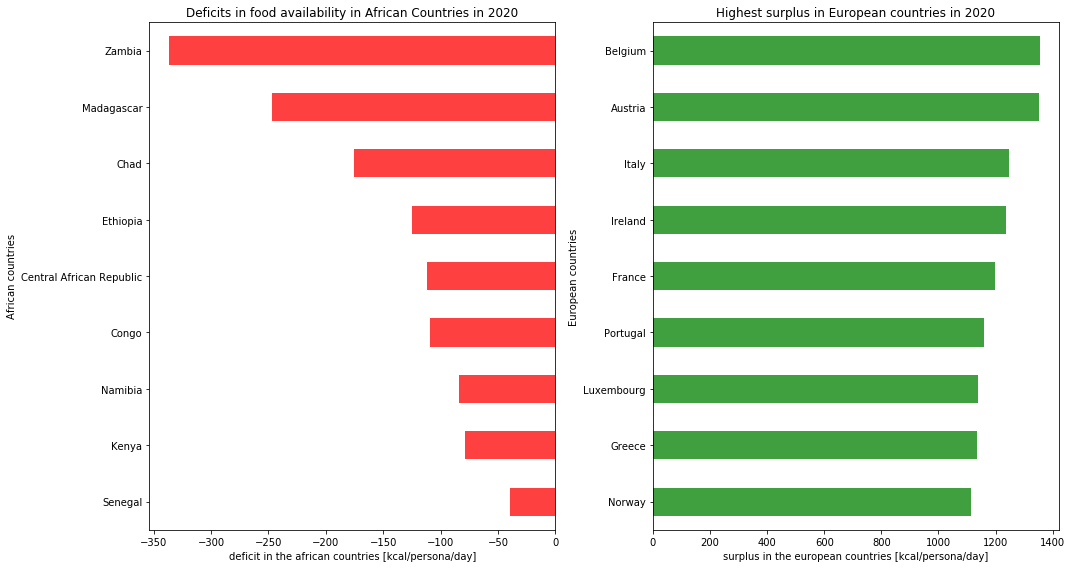

In [206]:
grid = plt.GridSpec(1,2)

# negative african countries
plt.subplot(grid[0, 0]);
p = caloric_difference_negative_africa.plot(kind='barh', color=(caloric_difference_negative_africa > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("deficit in the african countries [kcal/persona/day]")
p.set_ylabel("African countries")
plt.title('Deficits in food availability in African Countries in 2020' )

# highest surplus europe countries
plt.subplot(grid[0, 1]);
p1 = caloric_difference_highest_europe.plot(kind='barh', color=(caloric_difference_highest_europe > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p1.set_xlabel("surplus in the european countries [kcal/persona/day]")
p1.set_ylabel("European countries")
plt.title('Highest surplus in European countries in 2020' )

plt.tight_layout()
plt.show()

By looking at the difference between the most needing country **Zambia** and the country with the highest surplus **Belgium**, we see that Belgium alone has way more extra food than the lacking countries need individually. As such, we think that an interesting analysis to be made is which European countries could solve African hunger on their own. Below we analyse how much Africa needs in total, and how much Belgium alone "can" provide.

In [207]:
need_in_africa = abs(caloric_difference_negative_africa.sum())
print("The whole of Africa needs {0:.2f} extra kcal/person/day to solve hunger.".format(need_in_africa))

The whole of Africa needs 1306.82 extra kcal/person/day to solve hunger.


In [208]:
print("Belgium has {0:.2f} kcal/person/day over their basic needs.".format(caloric_difference_highest_europe['Belgium']))

Belgium has 1354.46 kcal/person/day over their basic needs.


We see that Belgium alone has 1354.46 *kcal/person/day*,almost **350** *kcal/person/day* over the need to solve the hunger in Africa! We therefore conclude that solving the hunger issue in Africa can be achieved by giving up a small fraction of the caloric quantities the "richest" countries have leftover.